# Analysis and Feature Selection

This notebook will analyise the energy load data used for the model. A contents of the analysis contained is described below.

## Analysis of energy load data
1. Plot the energy load data as a whole
    - Yearly line plot / box plot
    - Grouped by months line plot / box plot
    - Grouped by days of the week mean / box plot
    
2. Repeat section 1 with each of the hourly slices.
    - Divided by year line plot / box plot
    - Grouped by months line plot / box plot
    - Grouped by days of the week mean / box plot

3. Investigate stationarity of hourly segments
    - Why look at indivdual segments?
    - Plot of the distributions
    - Skew and kurtosis tests for normality + explanation of what this means
    - Augmented Dicky Fuller test per hourly segment + as a whole
    - Autoregressive plot and partial auto regressive plot (hourly + as a whole)
    - Differencing in preparation for modelling with ARIMAX 

## Analysis of features
1. Plots of weather temperature/humidity versus consumption
    - Yearly line plot
2. Plots of moving averages
    - MA 7, 14, 21, etc.
    - Multi plot of MAs for each hourly timeslice
3. Correlation plots of:
    - heat maps + pairplots
    - Autoregressive features + moving averages
    - Weather predictors


## TO DO
1. Add heatmap showing intensity of demand as color, x is hour of the day, y is day of the week


## Contents 
1. Energy data: general overview
2. Energy loads: hourly analysis





Summary of problem definition points to investigate. 
1. Inputs vs. Outputs: What are the inputs and outputs for a forecast?
2. Endogenous vs. Exogenous: What are the endogenous and exogenous variables?
3. Unstructured vs. Structured: Are the time series variables unstructured or structured?
4. Regression vs. Classification: Are you working on a regression or classification predictive modeling problem? What are some alternate ways to frame your time series forecasting problem?
5. Univariate vs. Multivariate: Are you working on a univariate or multivariate time series problem?
6. Single-step vs. Multi-step: Do you require a single-step or a multi-step forecast?
7. Static vs. Dynamic: Do you require a static or a dynamically updated model?
8. Contiguous vs. Discontiguous: Are your observations contiguous or discontiguous?


In [21]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from features_preprocessing import transform_to_windows, rename_cols

## Energy Data: Overview

Objective is to understand the structure of the energy demand data as a whole. Questions that help guide us are:

- What is the level, and noise varance, does the data contain any seasonal, or trending parts?
- Is the data stationary? If not can we make it stationary?
- What relationship is there between months and days of the year?
- What differences are there between the actual load and the predicted loads from Spain's TSO?

1. Plot the energy load data as a whole
    - Yearly line plot / box plot
    - Grouped by months line plot / box plot
    - Grouped by days of the week mean / box plot

In [3]:
#load the energy data
energy_data = pd.read_csv('./data/cleaned_data/energy_loads_2015_2019.csv', parse_dates=True, index_col='time')

#remove the 2019 data because it is incomplete and will affect the distributions.
energy_data = energy_data['2015':'2018']

energy_data.head()

,day_forecast,actual_load
time,,
2015-01-01 00:00:00,26118.0,25385.0
2015-01-01 01:00:00,24934.0,24382.0
2015-01-01 02:00:00,23515.0,22734.0
2015-01-01 03:00:00,22642.0,21286.0
2015-01-01 04:00:00,21785.0,20264.0


In [14]:
#statistical profile of loads
energy_data.describe()

,day_forecast,actual_load
count,35064.000000,35064.000000
mean,28712.354053,28698.592460
std,4593.742077,4575.338734
min,18105.000000,18041.000000
25%,24793.750000,24807.000000
50%,28906.000000,28902.000000
75%,32263.250000,32194.250000
max,41390.000000,41015.000000


In [15]:
mean_absolute_error(energy_data['actual_load'], energy_data['day_forecast'])

316.89292436687202

On inital inspection we see that the current short-term forecasts capture the same distribution as the actual. We see this in both their respective levels and inter quartile ranges. 

- Level of the forecasts is 28723 MWh
- Level of acutal demand is 28810 MWh

In supplying energy demand we are also interested in the baseload. The baseload is defined as the minimum demand over a period of time (usually weekly). In this case our global baseload is the minimum over the 4 years of data.
- Baseload is 18000 MWh

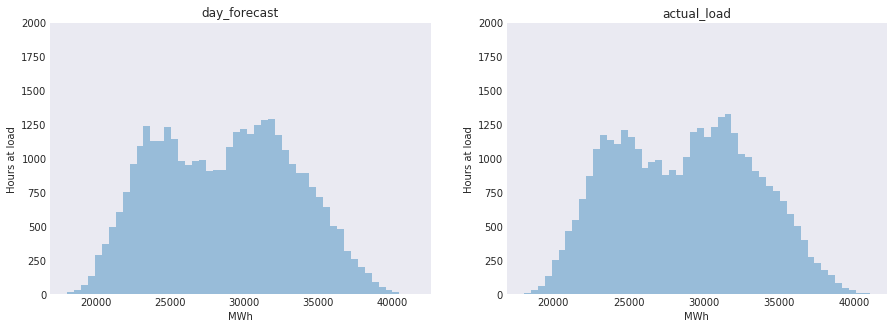

In [16]:
#visualize the distributions

fig, axs = plt.subplots(1, 2, figsize=(15,5))

#cycle through subplots and columns
for ax, col in zip(axs, energy_data.columns):
    #histogram plot
    sns.distplot(energy_data[col], ax=ax, kde=False, hist=True)
    #set axis labels
    ax.set_title(col)
    ax.set_xlabel('MWh')
    ax.set_ylabel('Hours at load')
    #set the y labels
    ax.set_yticks(np.linspace(0, 2000, 9))
    
plt.show()

Both actual and forecast load are bimodal distributions.

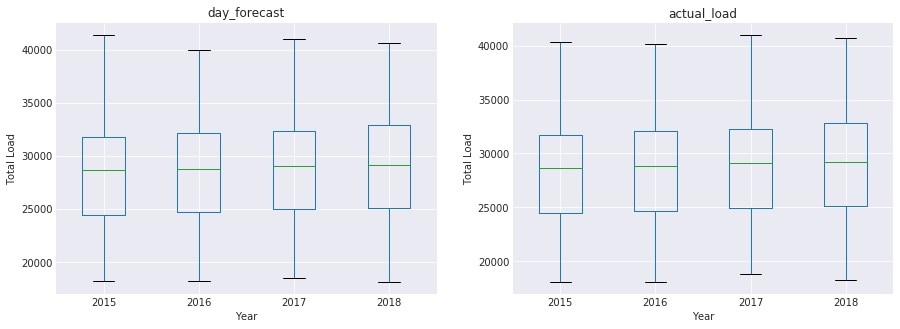

In [18]:
#group the data into years for plotting

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, energy_data.columns):
    groups = energy_data[col].groupby(pd.Grouper(freq='A'))

    df = pd.DataFrame()

    for name, group in groups:
        df[name.year] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Load')
    ax.set_title(col)

Yearly variability in the distributions is consistent in terms of the IQRs and median values. There appears a small trend of rising median actual load from 2015 to 2018.

There are no outliers as would be expected (an outlier in energy distribution would be a shortage or excess of power, both resulting in grid imbalance and high risk of downtime).

Only 2019 shows a larger IQR however this might be explained with only the ~5500 hours of load data availale at time of analysis.

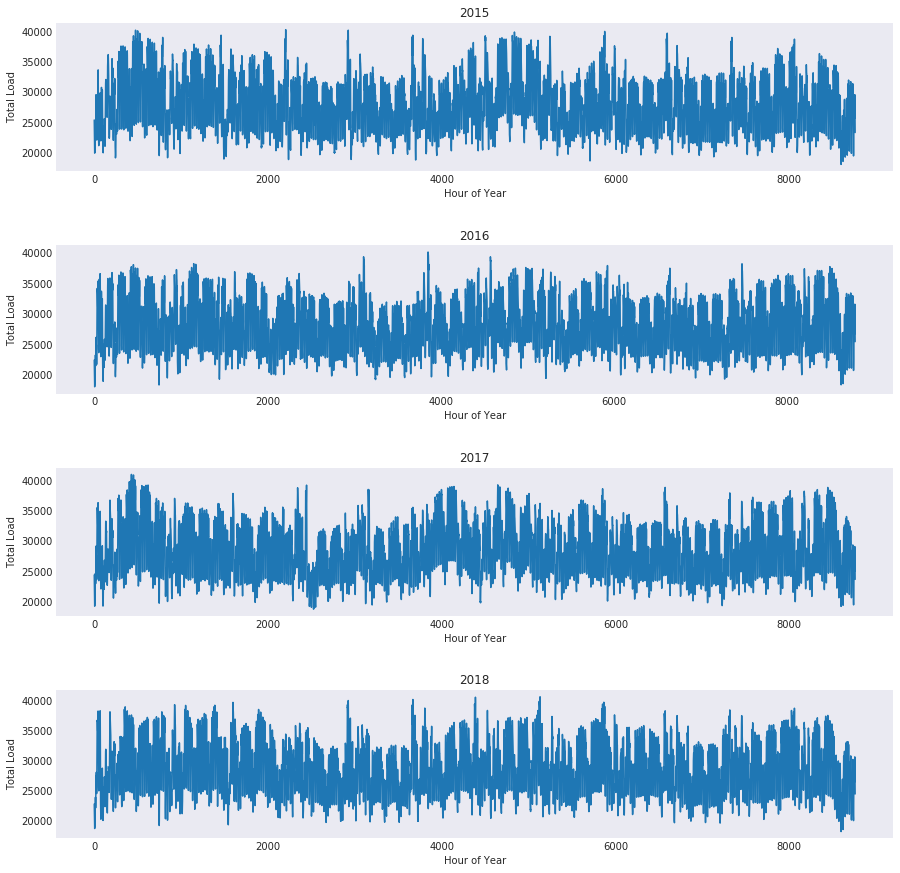

In [20]:
##### Plot the yearly actual loads

#group data by year
groups = energy_data['actual_load'].groupby(pd.Grouper(freq='A'))

#set figure and axis
fig, axs = plt.subplots(len(groups), 1, figsize=(15,15))


for ax, (name, group) in zip(axs, groups):
    
    #plot the data
    ax.plot(pd.Series(group.values))

    ax.set_xlabel('Hour of Year')
    ax.set_ylabel('Total Load')
    ax.set_title(name.year)
    plt.subplots_adjust(hspace=0.5)

Looking at the global load any seasonality is not obvious. In the summers of 2015 and 2017 there appears a spike in overall consumption.

### Demand Variability

##### Monthly demand variability

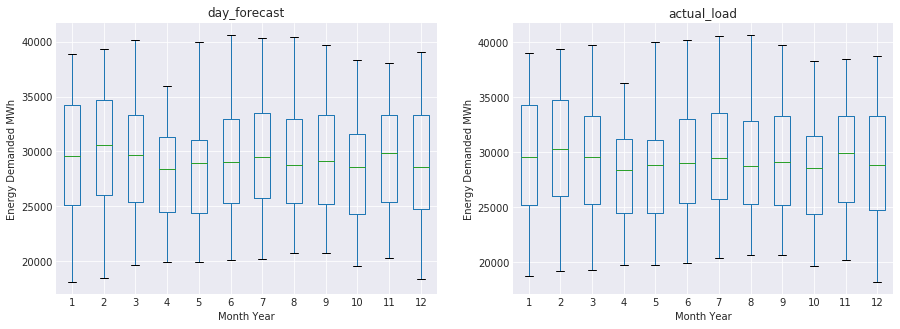

In [21]:
### plot the monthly demand variability. Looking for seasonal effects

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, energy_data.columns):
    
    groups = energy_data[col].groupby(pd.Grouper(freq='M'))
    
    df = pd.DataFrame()
    
    for name, group in groups:
        df[name.month] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Month Year')
    ax.set_ylabel('Energy Demanded MWh')
    ax.set_title(col)
    plt.subplots_adjust(hspace=0.5)
    
    
plt.show()

Actual loads shows clear seasonal trends through the year. The median actual load is highest in months 1,2,3 and 6,7,8. This corresponds to winter and summer months and is worth looking closer at temperature data to see if there is a correlation. 



##### Interweek demand variability

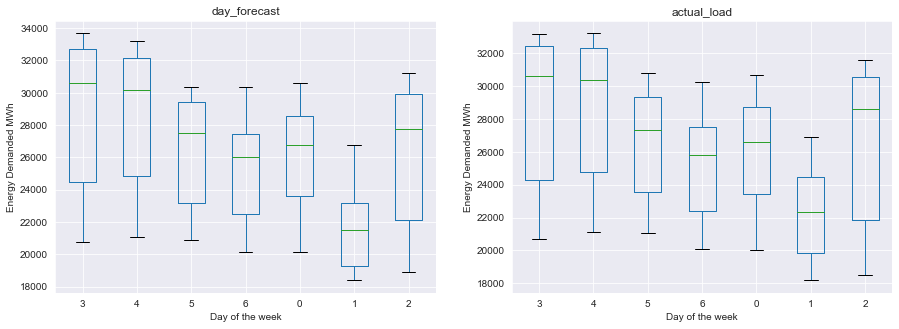

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, energy_data.columns):
    
    groups = energy_data[col].groupby(pd.Grouper(freq='D'))
    
    df = pd.DataFrame()
    
    for name, group in groups:
        df[name.dayofweek] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Day of the week')
    ax.set_ylabel('Energy Demanded MWh')
    ax.set_title(col)
    plt.subplots_adjust(hspace=0.5)
    
    
plt.show()

Days of the week show that weekends (days 5 and 6) have lower overall consumption. This is expected because in general businesses are not operating.

Also notice the median is in the upper range of the IQR. this is an indication that most of the power demanded is occuring in the upper band. This corresponds to the shape of the daily profile which will be seen in the next section. This observation supports the use of day vectors as features to identify the likely load demanded.

##### Daily profile variability

In [29]:
#transform the data into hourly windows
energy_data_transformed = transform_to_windows(energy_data)

    #rename the columns
demand_hourly = rename_cols(energy_data_transformed, shift=0)
demand_hourly.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0


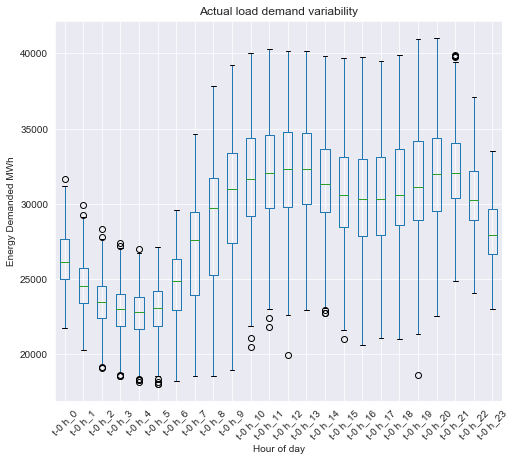

In [32]:
fig = plt.figure(figsize=(8,7))
demand_hourly.boxplot()
plt.xlabel('Hour of day')
plt.ylabel('Energy Demanded MWh')
plt.title('Actual load demand variability')
plt.xticks(rotation=45);

### Load Profile and Shape

##### Mean yearly profile

The mean load profile is our target for forecasting. As explained in the problem definition the objective is to model the short term load, 24 hours in advance.

The following graph shows 

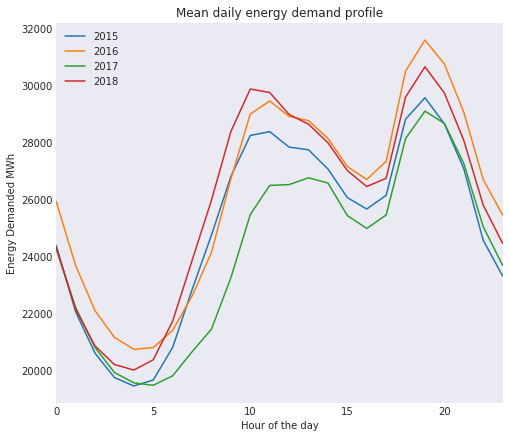

In [23]:
group_hours = energy_data['actual_load'].groupby(pd.Grouper(freq='D', how='mean'))

fig, axs = plt.subplots(1,1, figsize=(8,7))

df = pd.DataFrame()
    
for name, group in group_hours:
    df[name.year] = pd.Series(group.values)

df.plot(ax=axs)
axs.set_xlabel('Hour of the day')
axs.set_ylabel('Energy Demanded MWh')
axs.set_title('Mean daily energy demand profile');


##### Monthly mean load profile

/home/nicholas/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:179: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


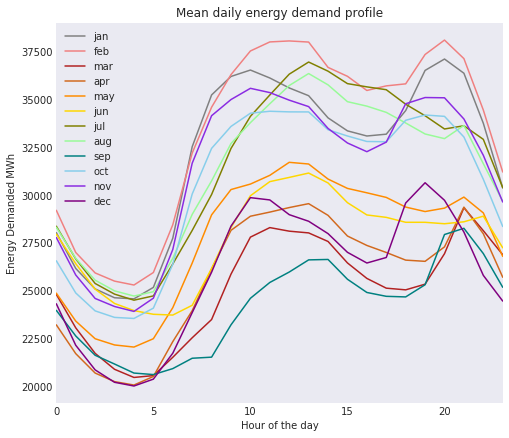

In [25]:
group_hours = energy_data['actual_load'].groupby(pd.Grouper(freq='D', how='mean'))

fig, axs = plt.subplots(1,1, figsize=(8,7))

df = pd.DataFrame()
    
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']    

for name, group in group_hours:
    df[name.month] = pd.Series(group.values)

    
colors = ['gray', 'lightcoral', 'firebrick', 'chocolate', 'darkorange', 'gold', 'olive', 'palegreen', 'teal', 'skyblue', 'blueviolet', 'purple']
df.columns = months
df.plot(ax=axs, colors=colors)
axs.set_xlabel('Hour of the day')
axs.set_ylabel('Energy Demanded MWh')
axs.set_title('Mean daily energy demand profile');


Mean energy load profile by month show a clear difference in seasonal profile. The months of jan, feb, jul, aug, oct, nov are on average seeing higher baseloads, and higher sustained load during peak hours.

The months of mar, apr, may, jun, and sep have comparably lower.

##### Interweek average load

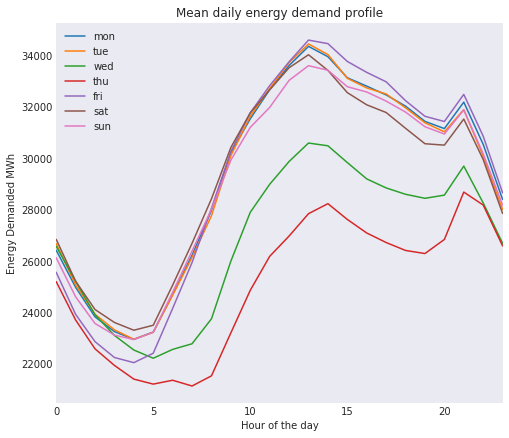

In [12]:
group_hours = energy_data['actual_load'].groupby(pd.Grouper(freq='D', how='mean'))

day_names = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

fig, axs = plt.subplots(1,1, figsize=(8,7))

df = pd.DataFrame()
    
for name, group in group_hours:
    df[name.dayofweek] = pd.Series(group.values)

df.columns = day_names
df.plot(ax=axs)
axs.set_xlabel('Hour of the day')
axs.set_ylabel('Energy Demanded MWh')
axs.set_title('Mean daily energy demand profile');

##### Ad fuller test for stationary

As noted above there appeared to be some seasonal anomalies in 2015 and 2017. The ad fuller test is a hypothesis test for timeseries stationarity. In this case we will test on the daily mean energy demanded. 

***Null Hypothesis***: The dataset is non-stationary and therefore differencing must be carried out.

If p-value is < 0.05 (two tailed test), we reject the null and assume that the time series is stationary.

When studying the indivdual hourly time series this will be repeated.

In [9]:
energy_daily = energy_data.groupby(pd.Grouper(freq='d'))

t = sm.tsa.adfuller(energy_daily['actual_load'].mean(), maxlag=365)
print(pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -6.097212e+00
p-value           1.003359e-07
#Lags             9.500000e+01
Observations      1.602000e+03
dtype: float64


Therefore we reject the null on the basis of a p-value <0.05. This means that as a whole the time series is stationary and ***does not*** need to be differenced. However this might not be the case when analysing the indivdual hourly slices.

# Hourly Energy Loads

The problem descrption describes how we are looking at forecasting 24 hours in advance. To do this we think about the problem as 24 indivdual forecasts. That is we use hour 0 of yesterday to forecast hour 0 of today.

The analysis above indcated that the general data was bimodal, stationary, showed differences in mean consumption by day of week, and month of the year.

The following analysis applies the same concepts to the hourly slices. The goal is to understand:

- Which hourly slices are stationary and should be differenced?
- To what extent do daily profiles change through the year?
- What are reasonable lag order and degrees of differencing for each hourly slice (used in ARIMAX model)

##### Mean hourly segments

In [12]:
#import package to transform energy data to hourly slices
from features_preprocessing import transform_to_windows

In [44]:
#transform data and have a look.
hourly_slices = transform_to_windows(energy_data, 'actual_load')

#drop 2019 data
hourly_slices = hourly_slices[:'2018']
hourly_slices.tail(3)

hours,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2018-12-29,25709.0,23622.0,22122.0,21368.0,21084.0,21168.0,21927.0,23347.0,24931.0,27300.0,...,28811.0,27815.0,27044.0,27317.0,29535.0,30271.0,30819.0,30718.0,29352.0,27332.0
2018-12-30,24922.0,22772.0,21301.0,20386.0,20103.0,20112.0,20651.0,21639.0,22662.0,24759.0,...,27264.0,26002.0,25313.0,25552.0,28072.0,29221.0,30042.0,30229.0,29145.0,26934.0
2018-12-31,24312.0,22140.0,20851.0,20200.0,20006.0,20366.0,21723.0,23850.0,25969.0,28382.0,...,27988.0,27009.0,26449.0,26738.0,29592.0,30653.0,29735.0,28071.0,25801.0,24455.0


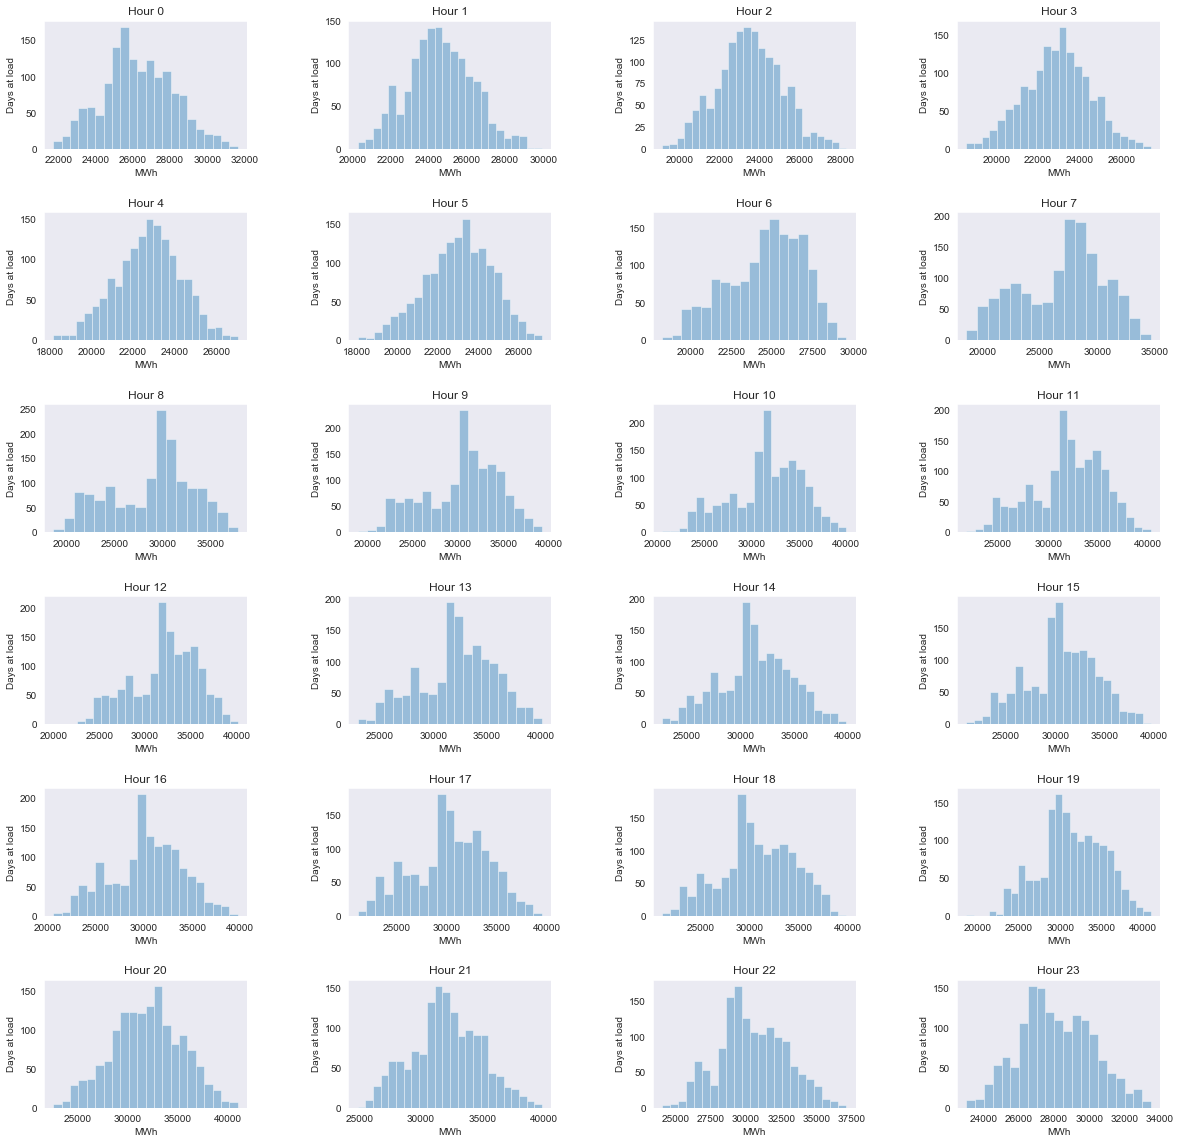

In [45]:
fig, axs = plt.subplots(6, 4, figsize=(20,20))

#cycle through subplots and columns
for ax, col in zip(axs.flatten(), hourly_slices.columns):
    #histogram plot
    sns.distplot(hourly_slices[col], ax=ax, kde=False, hist=True)
    #set axis labels
    ax.set_title('Hour ' + str(col))
    ax.set_xlabel('MWh')
    ax.set_ylabel('Days at load')
    #set the y labels
    #ax.set_yticks(np.linspace(0, 2000, 9))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
plt.show()

Hours 1-5: Closest to a normal distribution. 

Hours 6-15: Left skewed non normal.

Hours 16-19: Possibly slight right skew and bimodal.

Hours 20-21: Again close to normal distribution.

Hours 22-23: Starting to look like right skew. 

Take away is that the

In [46]:
hourly_slices.describe()

hours,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,...,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,26288.735797,24592.421629,23463.367556,22919.621834,22709.098563,23005.145791,24570.917864,26963.337098,28846.105407,30433.253936,...,31408.998175,30623.409841,30287.469694,30309.400867,30730.336832,31323.133166,31947.986995,32105.455510,30465.534223,28119.794319
std,1893.964563,1715.774022,1605.429316,1577.890693,1570.818559,1659.910598,2290.295341,3638.626943,4314.206989,4104.384914,...,3308.404380,3509.949170,3696.651149,3780.061622,3795.890176,3838.978811,3513.692898,2840.931845,2397.093617,2067.141780
min,21730.000000,20267.000000,19102.000000,18567.000000,18178.000000,18041.000000,18234.000000,18596.000000,18541.000000,18942.000000,...,22744.000000,21020.000000,20606.000000,21062.000000,21022.000000,18616.000000,22577.000000,24860.000000,24056.000000,23040.000000
25%,25024.000000,23449.000000,22420.000000,21892.000000,21685.000000,21877.000000,22922.000000,23930.000000,25305.000000,27430.000000,...,29436.000000,28465.000000,27879.000000,27908.000000,28582.000000,28924.000000,29511.000000,30376.000000,28914.000000,26690.000000
50%,26151.000000,24533.000000,23453.000000,22989.000000,22796.000000,23106.000000,24896.000000,27624.000000,29723.000000,30980.000000,...,31314.000000,30564.000000,30315.000000,30348.000000,30580.000000,31132.000000,32013.000000,32040.000000,30242.000000,27960.000000
75%,27639.000000,25760.000000,24533.000000,23998.000000,23811.000000,24201.000000,26374.000000,29458.000000,31698.000000,33409.000000,...,33672.000000,33100.000000,32963.000000,33103.000000,33651.000000,34173.000000,34381.000000,34068.000000,32218.000000,29639.000000
max,31638.000000,29934.000000,28307.000000,27414.000000,27022.000000,27146.000000,29564.000000,34672.000000,37836.000000,39251.000000,...,39825.000000,39657.000000,39724.000000,39510.000000,39898.000000,40939.000000,41015.000000,39880.000000,37133.000000,33495.000000


##### Annual variability of each hourly slice

Average variability for the 4 years for each hour.

24 rows, 1 col shoing year progress of consumption

In [ ]:
##### Plot the yearly actual loads

#set figure and axis
fig, axs = plt.subplots(24, 1, figsize=(15,30))

for col in hourly_slices.columns:
    
    #group data by year
    groups = hourly_slices[col].groupby(pd.Grouper(freq='h', how='mean'))

    for ax, (name, group) in zip(axs.flatten(), groups):

        #plot the data
        ax.plot(pd.Series(group.values))

        ax.set_xlabel('Day of year')
        ax.set_ylabel('Total Load')
        ax.set_title(name.year)
        plt.subplots_adjust(hspace=0.5)

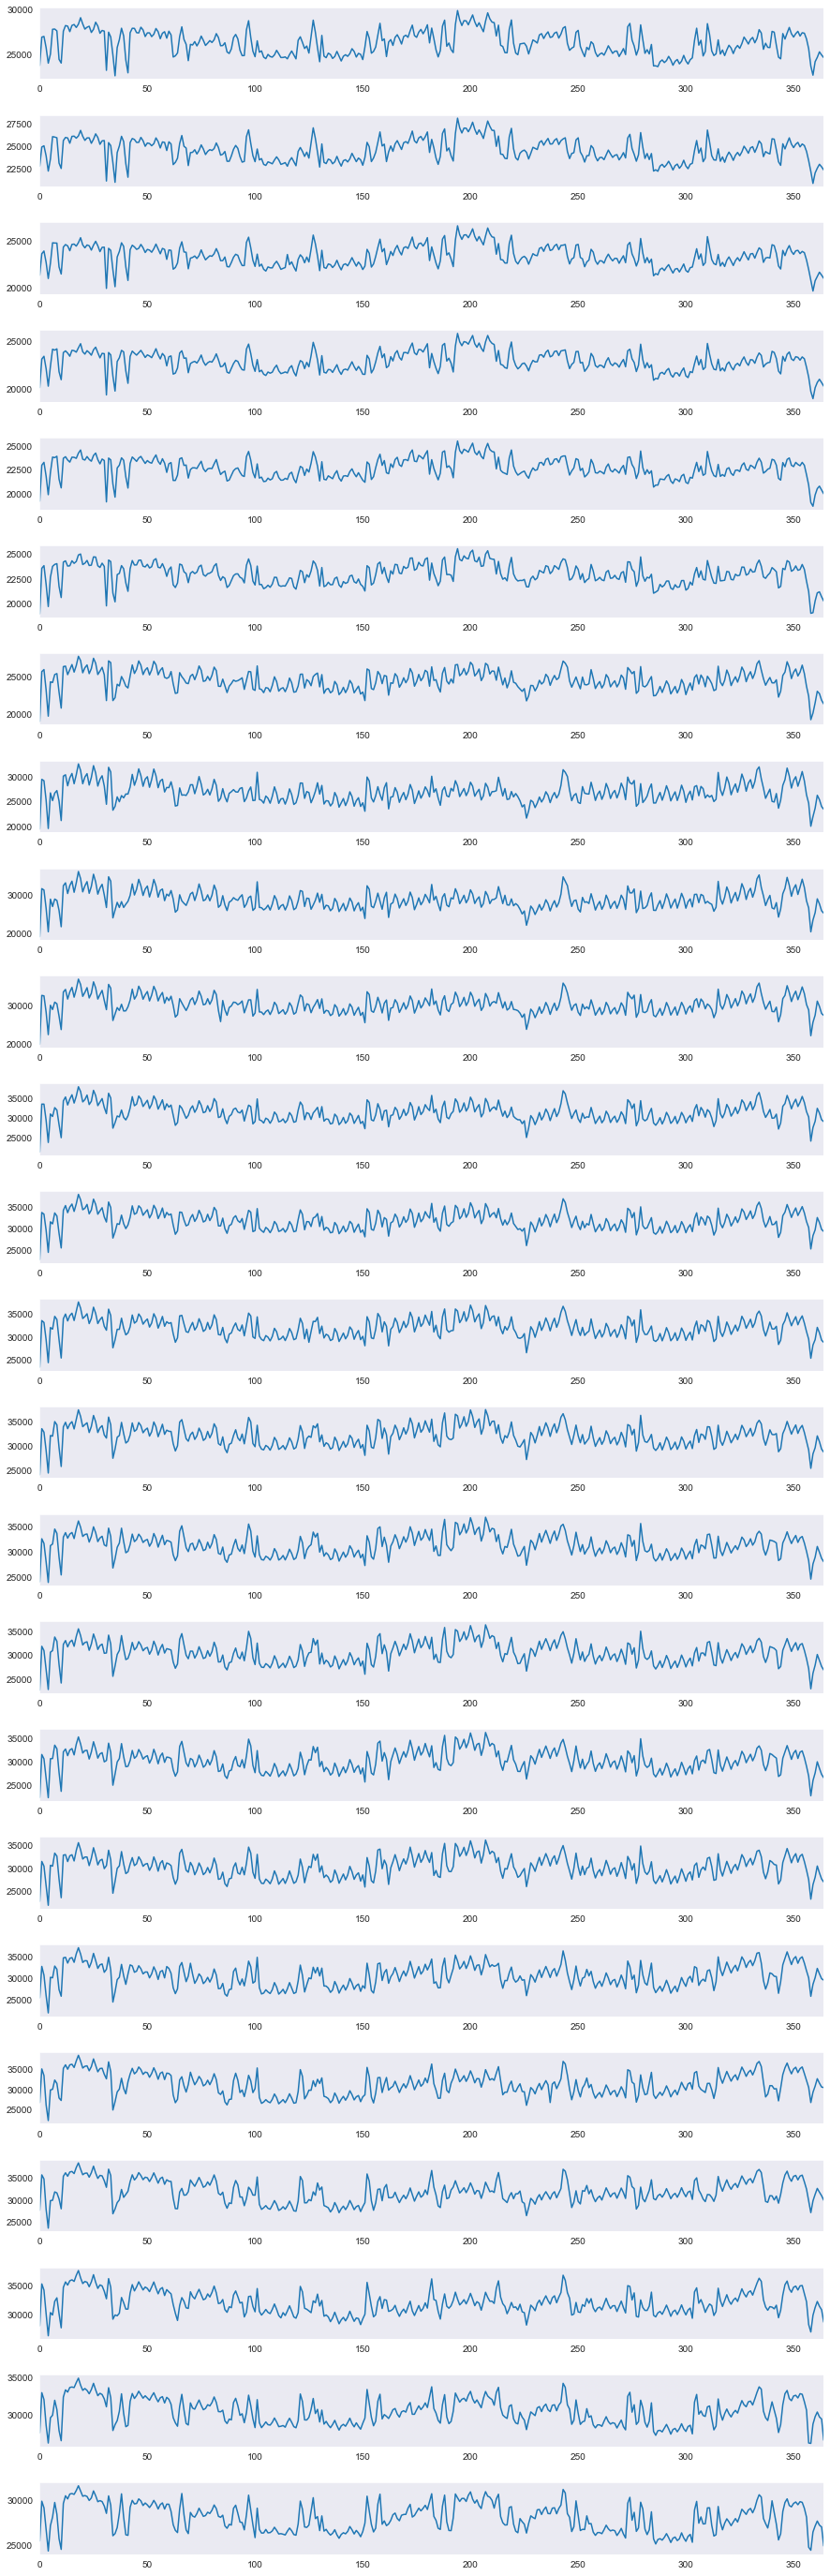

In [75]:
fig, axs = plt.subplots(24, 1, figsize=(15,50))

for ax, col in zip(axs.flatten(), hourly_slices.columns):
    
    groups = hourly_slices[col].groupby(pd.Grouper(freq='Y'))

    df = pd.DataFrame()

    for name, group in groups:
        df[name.year] = pd.Series(group.values)
    
    df.mean(axis=1).plot(ax=ax)
    plt.subplots_adjust(hspace=0.5)

##### Monthly variability of each hourly slice

##### Interweek variability of each hourly slice

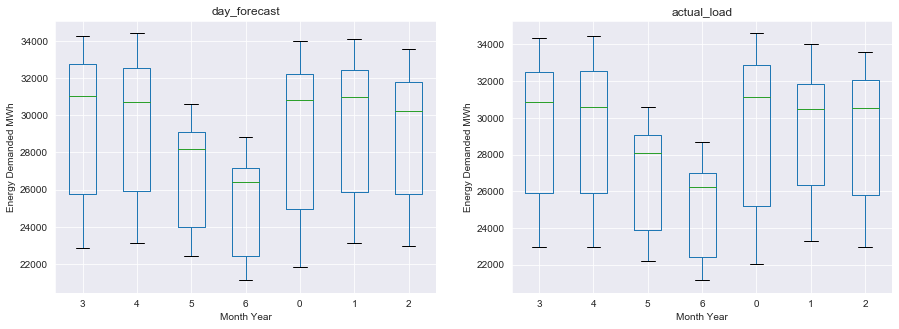

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, energy_data.columns):
    
    groups = energy_data[col].groupby(pd.Grouper(freq='D'))
    
    df = pd.DataFrame()
    
    for name, group in groups:
        df[name.dayofweek] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Month Year')
    ax.set_ylabel('Energy Demanded MWh')
    ax.set_title(col)
    plt.subplots_adjust(hspace=0.5)
    
    
plt.show()

A time series is said to be stationary if it doesn’t increase or decrease with time linearly or exponentially(no trends), and if it doesn’t show any kind of repeating patterns(no seasonality)